In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings('ignore')


def lstm_sliding_window_prediction(area: str):
    # 1. 創建模擬時間序列數據
    data = pd.read_csv(r"data\owid-covid-data.csv")

    # 選擇某一地區的數據進行分析，例如 "World"
    region_data = data[data['iso_code'] == area]
    region_data['new_cases_smoothed'] = region_data['new_cases_smoothed'].fillna(0)  # 填充缺失值

    # 2. 數據標準化 (z-score)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(region_data['new_cases_smoothed'].values.reshape(-1, 1))

    # 使用移動窗格創建時間序列數據集
    def create_sliding_window_dataset(data, window_size=10):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, 0])
            y.append(data[i + window_size, 0])
        return np.array(X), np.array(y)

    # 定義窗口大小
    window_size = 28

    # 創建滑動窗口數據集
    X, y = create_sliding_window_dataset(standardized_data, window_size)

    # 重塑 X 為 LSTM 的輸入格式 (樣本數, 時間步長, 特徵數)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 分割為訓練集和測試集
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 3. 構建 LSTM 模型
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)  # 單一輸出值
    ])

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # 4. 訓練模型
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # 5. 預測並還原預測結果
    predicted_cases = model.predict(X_test)
    predicted_cases = scaler.inverse_transform(predicted_cases)  # 還原標準化

    # 還原測試集實際值
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 6. 視覺化結果
    plt.figure(figsize=(20, 6))
    plt.plot(region_data['date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Cases')
    plt.plot(region_data['date'][-len(predicted_cases):], predicted_cases, color='red', label='Predicted Cases')
    plt.title('Sliding Window Prediction (New COVID Cases)')
    plt.xlabel('Date')
    plt.ylabel('New Cases Smoothed')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # 7. 評估模型
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    def calculate_mape(true_values, predictions):
        """
        計算 Mean Absolute Percentage Error (MAPE)
        """
        true_values = np.array(true_values)
        predictions = np.array(predictions)
        return np.mean(np.abs((true_values - predictions) / true_values)) * 100

    def calculate_ppe(true_values, predictions):
        """
        計算 Peak Prediction Error (PPE)
        """
        peak_true_value = np.max(true_values)
        peak_true_time = np.argmax(true_values)

        peak_pred_value = np.max(predictions)
        peak_pred_time = np.argmax(predictions)

        value_error = np.abs(peak_true_value - peak_pred_value)
        time_error = np.abs(peak_true_time - peak_pred_time)

        return value_error, time_error

    mae = mean_absolute_error(y_test_actual, predicted_cases)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_cases))
    mape = calculate_mape(y_test_actual, predicted_cases)
    ppe_value_error, ppe_time_error = calculate_ppe(y_test_actual, predicted_cases)

    print(f'MAE: {mae}')
    print(f'MAE / Mean: {mae / np.mean(y_test_actual)}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')
    print(f'Peak Prediction Error (Value): {ppe_value_error}')
    print(f'Peak Prediction Error (Time): {ppe_time_error} days')


In [4]:
regions=["MYS", "ARG", "MEX", "JPN", "CAN", "THA", "VNM", "TWN", "CHN", "SGP"]

Region: MYS
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


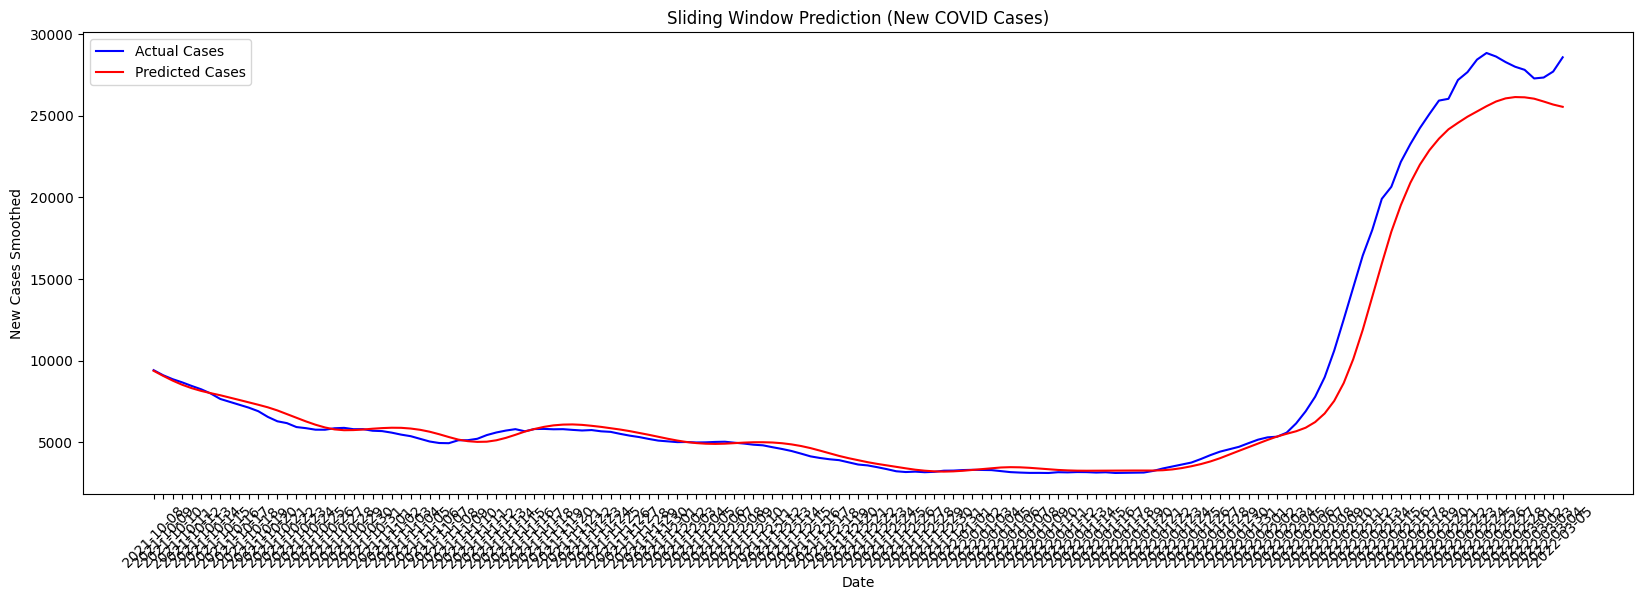

MAE: 674.9632969667575
MAE / Mean: 0.08271261082555352
RMSE: 1227.4884246196248
MAPE: 6.51%
Peak Prediction Error (Value): 2699.27275
Peak Prediction Error (Time): 3 days
Region: ARG
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


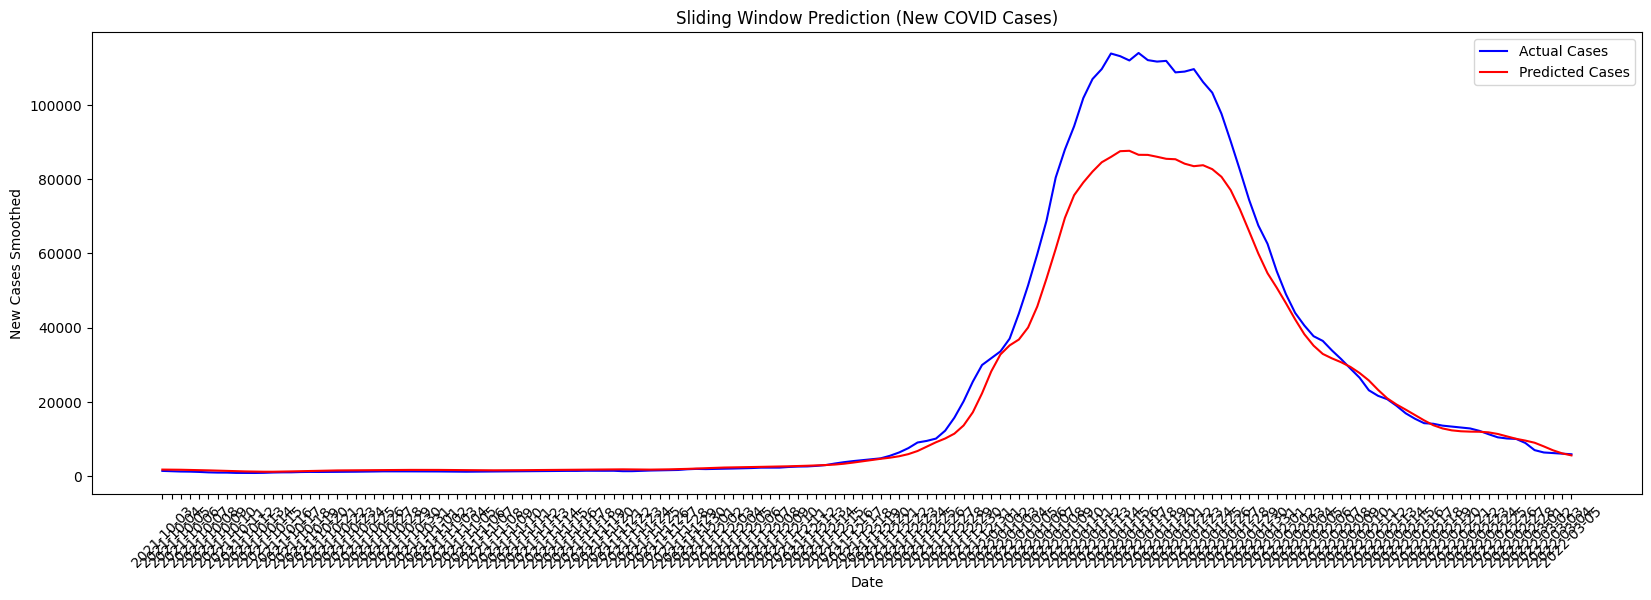

MAE: 4233.295122323964
MAE / Mean: 0.17816397121545527
RMSE: 8863.729247433177
MAPE: 20.03%
Peak Prediction Error (Value): 26371.95550000001
Peak Prediction Error (Time): 1 days
Region: MEX
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002C3BCE4A050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


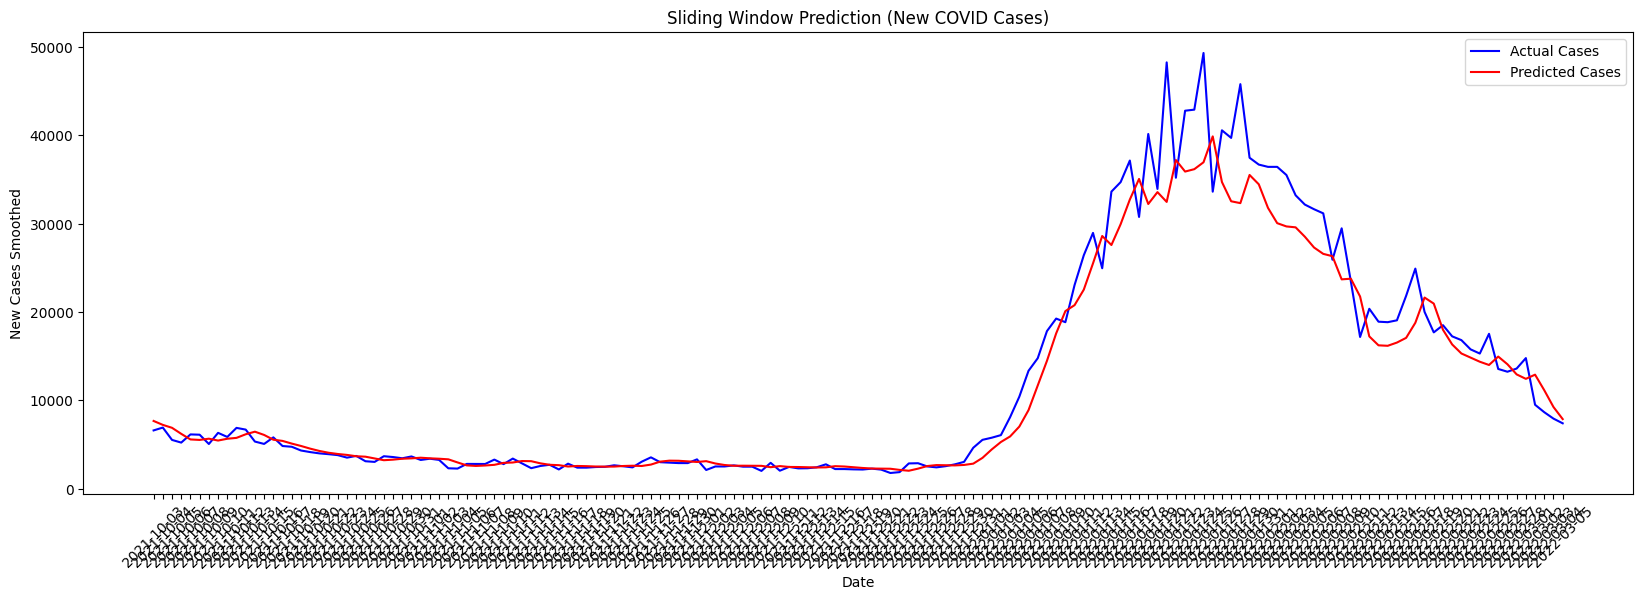

MAE: 1766.063630618405
MAE / Mean: 0.1452526823321963
RMSE: 3098.388743733
MAPE: 13.11%
Peak Prediction Error (Value): 9439.9453125
Peak Prediction Error (Time): 1 days
Region: JPN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


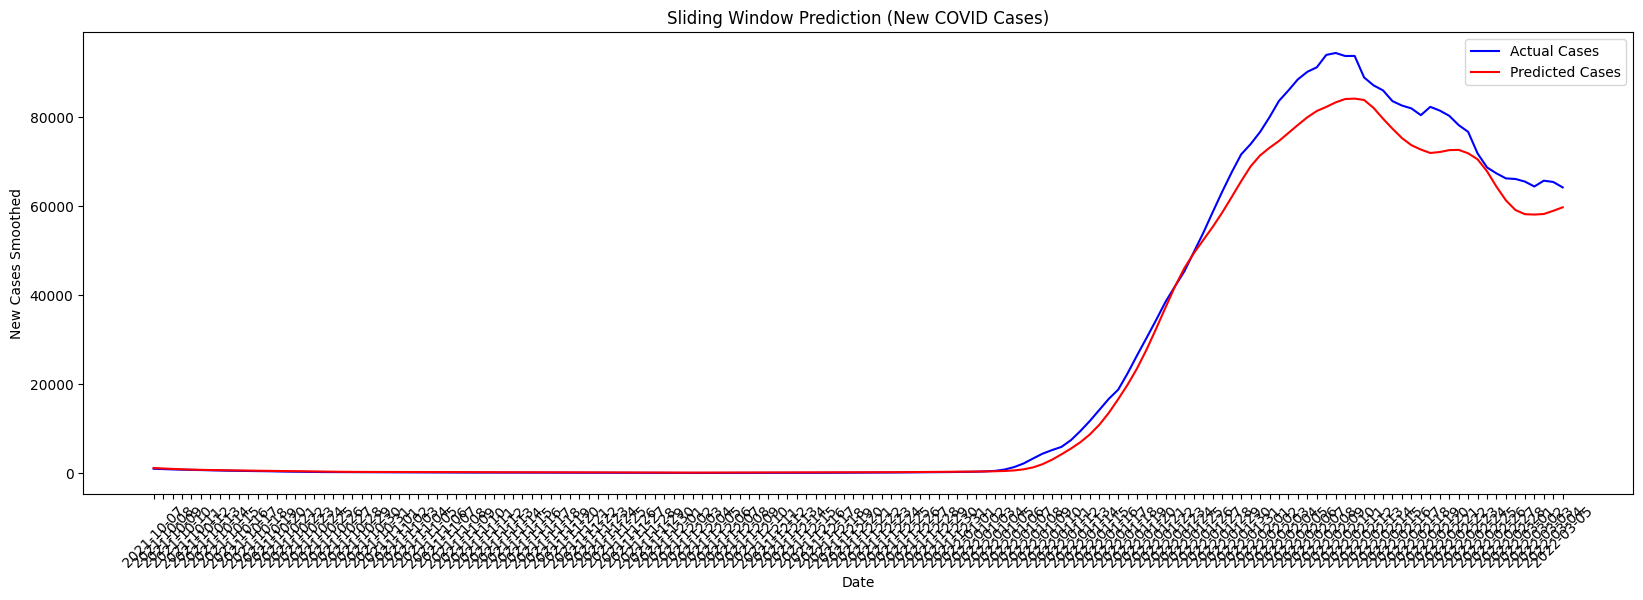

MAE: 2060.015323152669
MAE / Mean: 0.08993953674292673
RMSE: 3773.4959976591163
MAPE: 34.06%
Peak Prediction Error (Value): 10253.1484375
Peak Prediction Error (Time): 2 days
Region: CAN
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


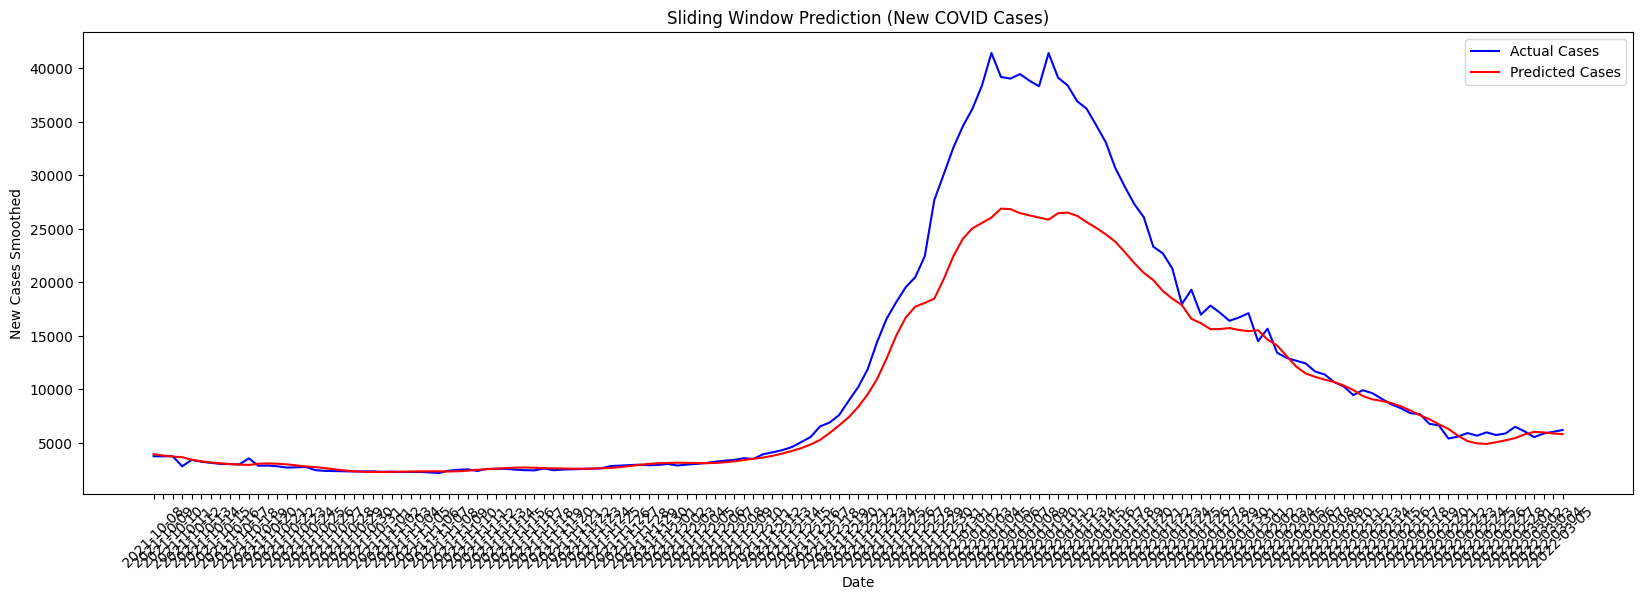

MAE: 2152.3680763029574
MAE / Mean: 0.1919922690799487
RMSE: 4433.301700970328
MAPE: 10.39%
Peak Prediction Error (Value): 14551.395375
Peak Prediction Error (Time): 1 days
Region: THA
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


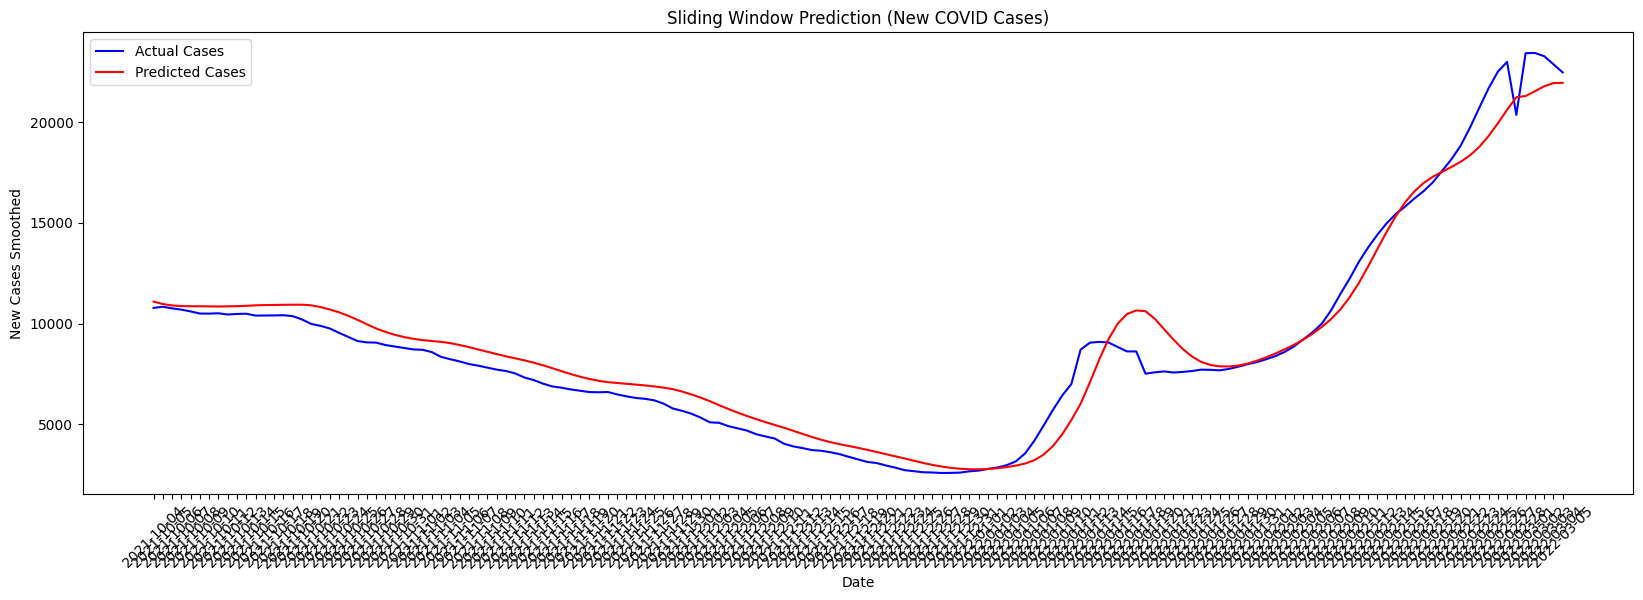

MAE: 756.6273201720793
MAE / Mean: 0.08564094167166643
RMSE: 963.5424708683364
MAPE: 10.30%
Peak Prediction Error (Value): 1477.708140625
Peak Prediction Error (Time): 3 days
Region: VNM
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


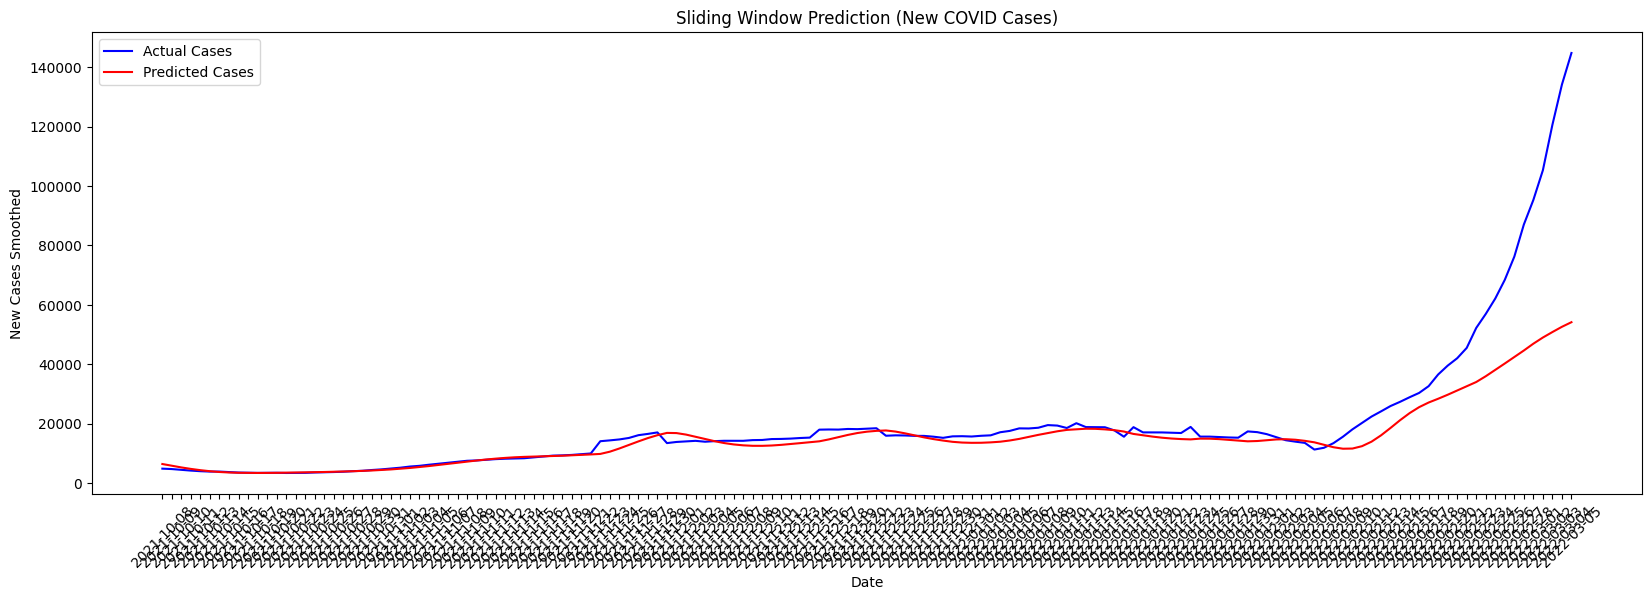

MAE: 5168.4906523437485
MAE / Mean: 0.26273571625708564
RMSE: 14548.193707697903
MAPE: 13.40%
Peak Prediction Error (Value): 90618.78209375
Peak Prediction Error (Time): 0 days
Region: TWN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


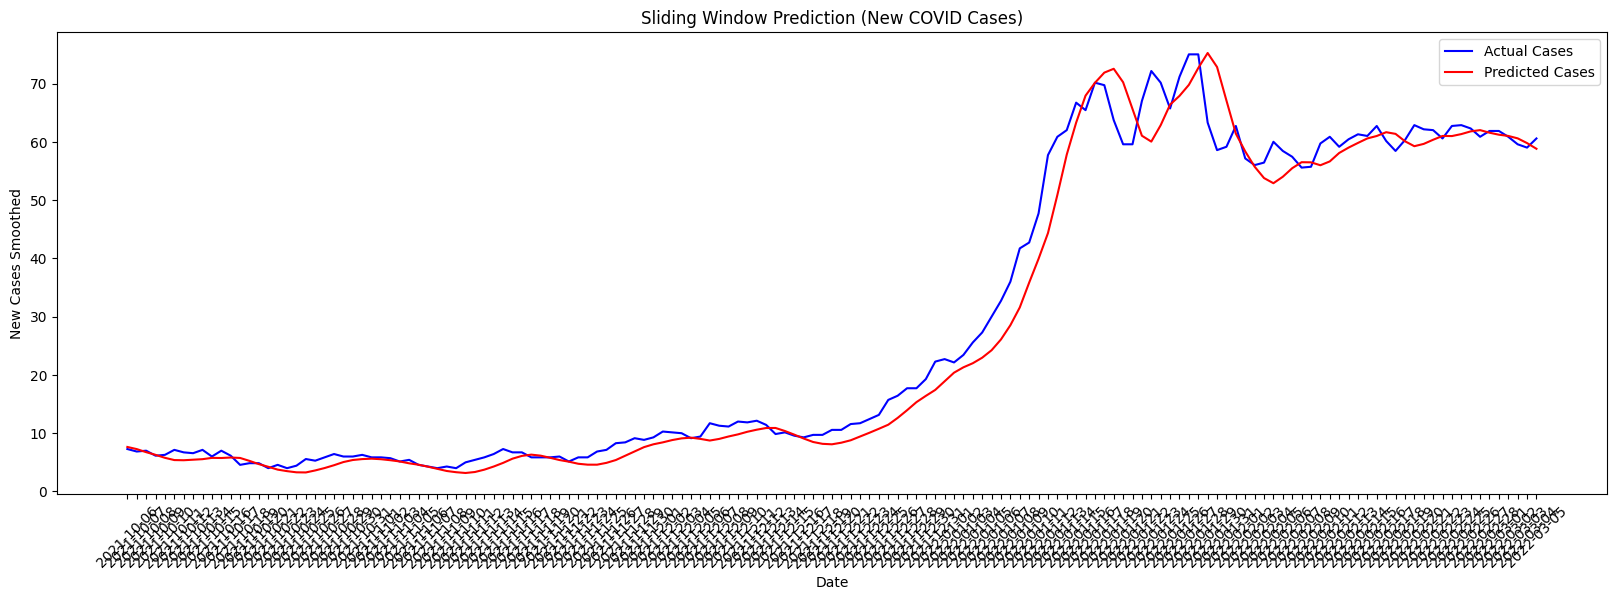

MAE: 2.417045777984013
MAE / Mean: 0.0837096513520387
RMSE: 3.6875545833871968
MAPE: 12.24%
Peak Prediction Error (Value): 0.2351531982421875
Peak Prediction Error (Time): 2 days
Region: CHN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


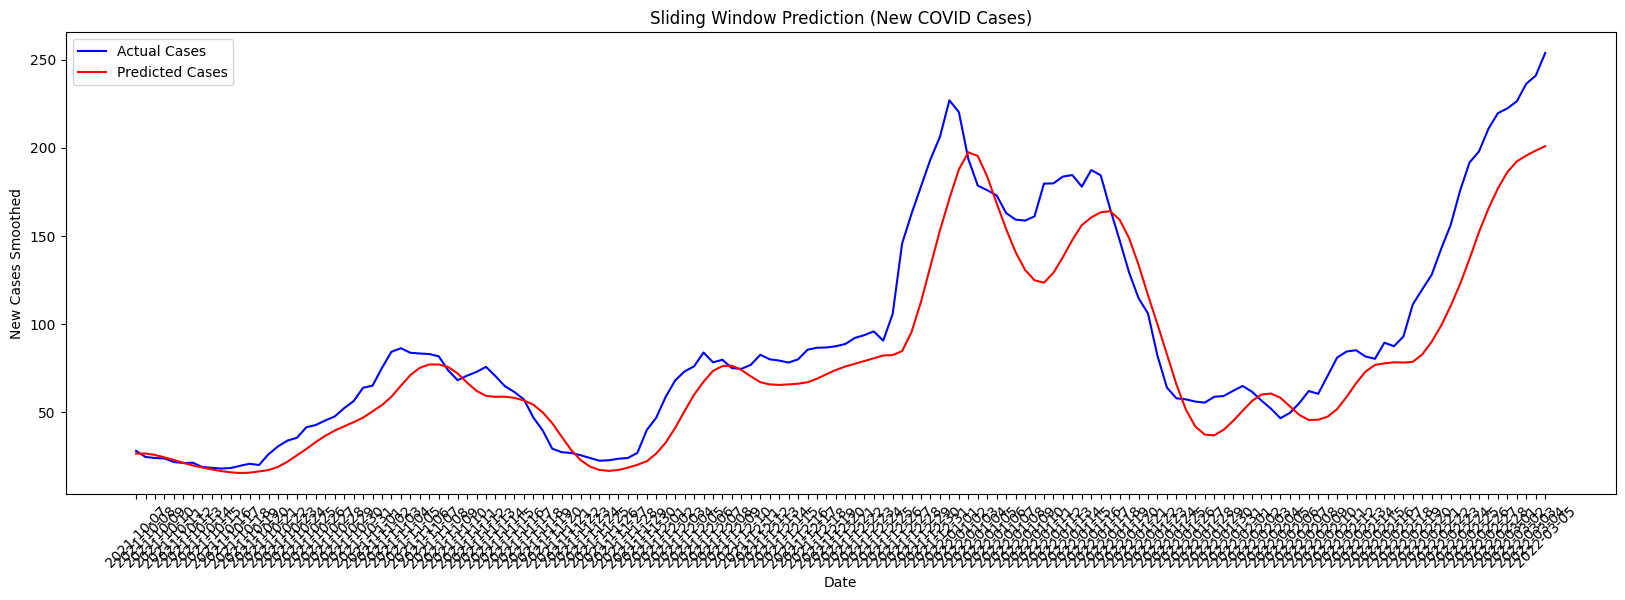

MAE: 17.619387426300047
MAE / Mean: 0.19181698397368954
RMSE: 23.68984822132606
MAPE: 19.05%
Peak Prediction Error (Value): 52.899714721679686
Peak Prediction Error (Time): 0 days
Region: SGP
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


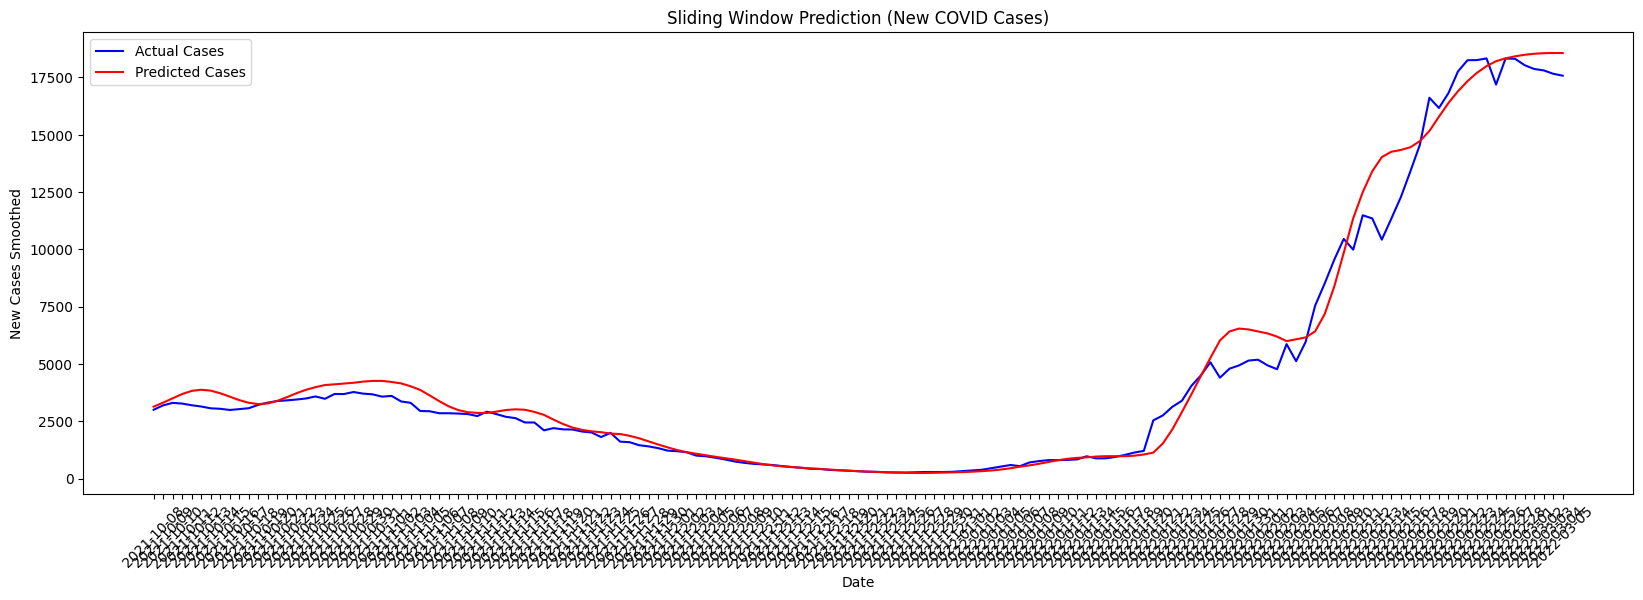

MAE: 447.51238001389464
MAE / Mean: 0.10127214283260612
RMSE: 727.0348115808408
MAPE: 11.52%
Peak Prediction Error (Value): 237.13629687499997
Peak Prediction Error (Time): 7 days


In [5]:
for region in regions:
    print("=" * 50)
    print(f"Region: {region}")
    
    lstm_sliding_window_prediction(region)

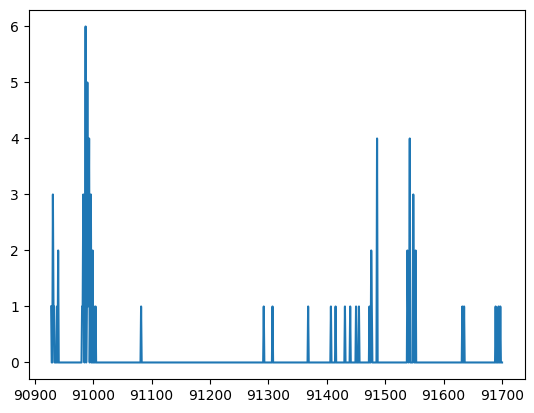

In [49]:
data = pd.read_csv(r"data\owid-covid-data.csv")
region_data = data[data['iso_code'] == "MAC"]
from matplotlib.pyplot import plot
plot(region_data["new_cases"])

In [51]:
region_data["new_cases"].describe()

count    773.000000
mean       0.104787
std        0.504529
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: new_cases, dtype: float64